# **Problem Statement:**

From an Image dataset we need to find N similar images on a given query image

# **Importing Data:**

**Loading Data by dragging:**

*    Using CurlWget method takes couple of seconds to load the data.

**Note1:** When the PC gets turned off all the data you loaded through it will get lost. So you need to load the data again when you run the below code snippets.

**Note2:** CurlWget gives a .zip file. So we need to unzip the folders before using it.

**Mounting Google Drive:**

To access/create files in google drive

**Loading Dependencies:**

In [4]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from keras.optimizers import Adam, Adagrad, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

Rename the images in dataset

In [5]:
# Specify the directory path
directory = './dataset/'

# Iterate over the files in the directory
for no, filename in enumerate(os.listdir(directory), 1):
    # Check if the file is a regular file
    if os.path.isfile(os.path.join(directory, filename)):
        # Specify the new file name format
        new_filename = str(no) + '.jpg'
        
        # Check if the new filename already exists
        if not os.path.exists(os.path.join(directory, new_filename)):
            # Rename the file
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
        else:
            new_filename = str(no) + 'z.jpg'
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './dataset/1.jpg' -> './dataset/1z.jpg'

*    I am using tensorflow.keras (2.0 version) throughout this assignment.
*    I am doing this case study in google colab. So all the paths will be specified according to colab directories.

In [3]:
file_path = os.listdir('dataset')
print(len(file_path))

4131


*    Their are of total 4130 images.
*    Since the dataset is small we need to take of model training so that it won't get overfit or underfit.
*    Interestingly all the images are in same resolution. (512x512)

**Splitting the data into Train & Test sets:**

In [4]:
train_files, test_files = train_test_split(file_path, test_size = 0.15)
print(len(train_files))
print(len(test_files))

train_files = pd.DataFrame(train_files,columns=['filepath'])
test_files = pd.DataFrame(test_files,columns=['filepath'])
#converting into .csv file for future reference.
train_files.to_csv('train_file.csv')
test_files.to_csv('test_file.csv')

3511
620


In [5]:
#loading csv files. 
train_files = list(pd.read_csv('train_file.csv')['filepath'])
test_files = list(pd.read_csv('test_file.csv')['filepath'])

*    Taking the file path of all the images and splitting that list into train and test. So that their will be no need of splitting the data again in future and we can access those sets directly by storing it in drive.
*    Storing the end result into .csv format so that their will be no data leakage problems in future.

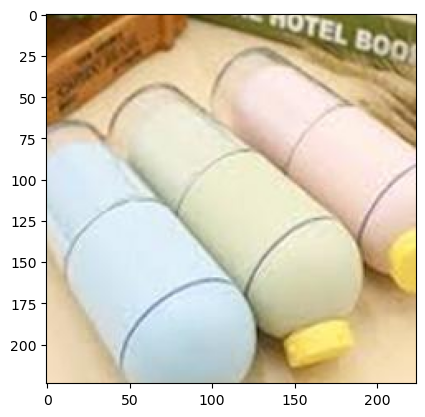

In [6]:
img = cv2.imread('dataset/'+train_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

**Reading Images:**

In [7]:
def image2array(file_array):

    """
    Reading and Converting images into numpy array by taking path of images.
    Arguments:
    file_array - (list) - list of file(path) names
    Returns:
    A numpy array of images. (np.ndarray)
    """

    image_array = []
    for path in tqdm(file_array):
        img = cv2.imread('dataset/'+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image_array.append(np.array(img))
    image_array = np.array(image_array)
    image_array = image_array.reshape(image_array.shape[0], 224, 224, 3) 
    image_array = image_array.astype('float32')
    image_array /= 255 
    return np.array(image_array)

In [8]:
train_data = image2array(train_files)
print("Length of training dataset:",train_data.shape)
test_data = image2array(test_files)
print("Length of test dataset:",test_data.shape)

100%|██████████| 3511/3511 [00:32<00:00, 107.25it/s]


Length of training dataset: (3511, 224, 224, 3)


100%|██████████| 620/620 [00:05<00:00, 107.40it/s]


Length of test dataset: (620, 224, 224, 3)


# **Model Architecture & Model Training:**

In [19]:
def encoder_decoder_model():
    model = Sequential(name='Optimized_Convolutional_AutoEncoder_Model')
    
    # Encoder
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), padding='same', name='Encoding_Conv2D_1'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_1'))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv2D_2'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_2'))
    
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv2D_3'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_3'))
    
    # Decoder
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv2D_1'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2), name='Decoding_Upsampling2D_1'))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv2D_2'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2), name='Decoding_Upsampling2D_2'))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv2D_3'))
    model.add(BatchNormalization())
    model.add(UpSampling2D((2, 2), name='Decoding_Upsampling2D_3'))
    
    model.add(Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same', name='Decoding_Output'))
    
    return model

Model: "Optimized_Convolutional_AutoEncoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoding_Conv2D_1 (Conv2D)  (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 Encoding_MaxPooling2D_1 (M  (None, 112, 112, 64)      0         
 axPooling2D)                                                    
                                                                 
 Encoding_Conv2D_2 (Conv2D)  (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 128)     512       
 chNormalization)                                                
                         

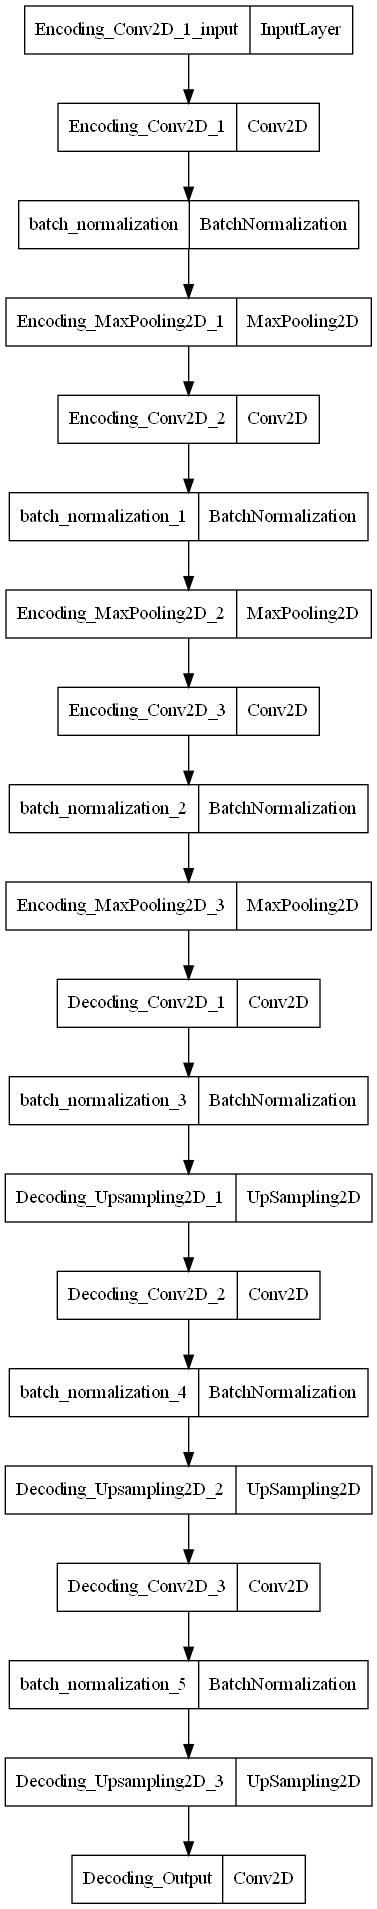

In [20]:
# model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model = encoder_decoder_model()
model.summary()
print("\n")
tf.keras.utils.plot_model(model, to_file='dataset/1.jpg')

**Hyper parameter Tuning:**

In [21]:
# Defining hyperparameters for optimization
parameters = {'Adagrad': [0.01, 0.001, 0.0001, 0.00001], 'Adam': [0.01, 0.001, 0.0001, 0.00001], 'Rmsprop': [0.01, 0.001, 0.0001, 0.00001]}

# Function to train models with different optimizers and learning rates
def train_models(train_data, test_data, parameters):
    results = {}
    for optimizer_name, learning_rates in parameters.items():
        print(f"Optimizer: {optimizer_name}")
        optimizer_results = {}
        for learning_rate in learning_rates:
            print(f"\tLearning Rate: {learning_rate}")
            model = encoder_decoder_model()
            optimizer = None
            if optimizer_name == 'Adam':
                optimizer = Adam(learning_rate=learning_rate)
            elif optimizer_name == 'Adagrad':
                optimizer = Adagrad(learning_rate=learning_rate)
            else:
                optimizer = RMSprop(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='mse')
            # Using early stopping callback
            early_stopping = EarlyStopping(monitor='val_loss', patience=3)
            history = model.fit(train_data, train_data, epochs=5, batch_size=128, validation_data=(test_data, test_data), callbacks=[early_stopping])
            optimizer_results[learning_rate] = history.history
        results[optimizer_name] = optimizer_results
    return results


In [22]:
# Training models with different optimizers and learning rates
results = train_models(train_data, test_data, parameters)

Optimizer: Adagrad
	Learning Rate: 0.01
Epoch 1/5
 3/28 [==>...........................] - ETA: 13:41 - loss: 0.1142

KeyboardInterrupt: 

In [ ]:
def plot_(x,y1,y2,row,col,ind,title,xlabel,ylabel,label,isimage=False,color='r'):

    """
    This function is used for plotting images and graphs (Visualization of end results of model training)
    Arguments:
    x - (np.ndarray or list) - an image array
    y1 - (list) - for plotting graph on left side.
    y2 - (list) - for plotting graph on right side.
    row - (int) - row number of subplot
    col - (int) - column number of subplot
    ind - (int) - index number of subplot
    title - (string) - title of the plot 
    xlabel - (list) - labels of x axis
    ylabel - (list) - labels of y axis
    label - (string) - for adding legend in the plot
    isimage - (boolean) - True in case of image else False
    color - (char) - color of the plot (prefered green for training and red for testing).
    """
    
    plt.subplot(row,col,ind)
    if isimage:
        plt.imshow(x)
        plt.title(title)
        plt.axis('off')
    else:
        plt.plot(y1,label=label,color='g'); plt.scatter(x,y1,color='g')
        if y2!='': plt.plot(y2,color=color,label='validation'); plt.scatter(x,y2,color=color)
        plt.grid()
        plt.legend()
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

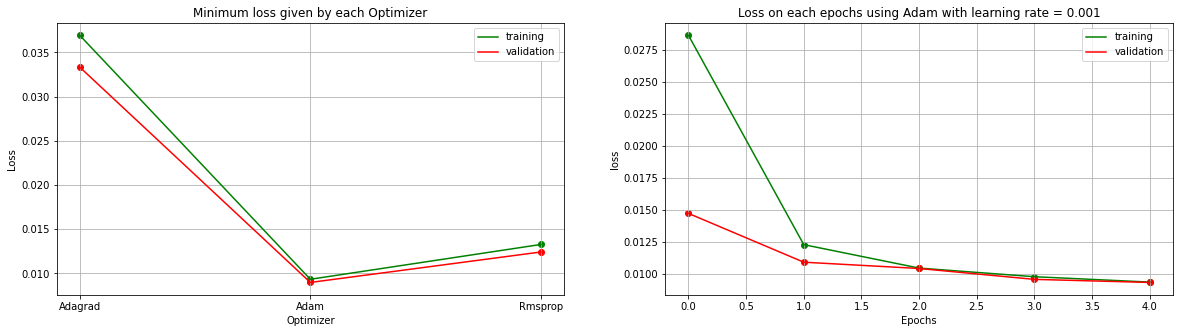

In [ ]:
min_train = []; min_val = []  
rates = list(parameters.keys())
epochs = [0,1,2,3,4]
for i in results:
    train = []; val = []
    for j in i:
        train.append(min(j['loss'])); val.append(min(j['val_loss']))  # taking minimum loss of each optimizer over all learning rates.
    min_train.append(min(train)); min_val.append(min(val))
plt.figure(figsize=(20,5))
plot_(rates,min_train,min_val,1,2,1,'Minimum loss given by each Optimizer','Optimizer','Loss','training',False,'r')
# plotting the result of adam with learning rate = 0.001 .
plot_(epochs, results[1][1]['loss'],results[1][1]['val_loss'],1,2,2,'Loss on each epochs using Adam with learning rate = 0.001','Epochs','loss','training',False,'r')
plt.show()

*    After training the model with different optimizers(Adagrad, Adam, Rmsprop), adam giving the least local minimum loss on training with learning rate = 0.001.
*    Both training loss and validation loss are almost equal and we can see our model training is not prone to overfitting and underfitting.
*    Achieved 0.0093 on five epochs using Adam(0.001)(optimal value).


**Training the model with Best Optimizer with Best Learning Rate:**

In [ ]:
optimizer = Adam(learning_rate=0.001) 
model = encoder_decoder_model() 
model.compile(optimizer=optimizer, loss='mse') 
early_stopping = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=6,min_delta=0.0001) 
checkpoint = ModelCheckpoint('/content/drive/My Drive/encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True) 
model.fit(train_data, train_data, epochs=35, batch_size=32,validation_data=(test_data,test_data),callbacks=[early_stopping,checkpoint]) 

Epoch 1/35
126/126 [==============================] - 20s 156ms/step - loss: 0.0234 - val_loss: 0.0128
Epoch 2/35
126/126 [==============================] - 20s 156ms/step - loss: 0.0113 - val_loss: 0.0105
Epoch 3/35
126/126 [==============================] - 20s 157ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 4/35
126/126 [==============================] - 20s 158ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 5/35
126/126 [==============================] - 20s 157ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 6/35
126/126 [==============================] - 20s 157ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 7/35
126/126 [==============================] - 20s 157ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 8/35
126/126 [==============================] - 20s 155ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 9/35
126/126 [==============================] - 20s 157ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 10/35
126/126 [==============================] - 20s 155ms/step - l

**Plotting loss on each epoch:**

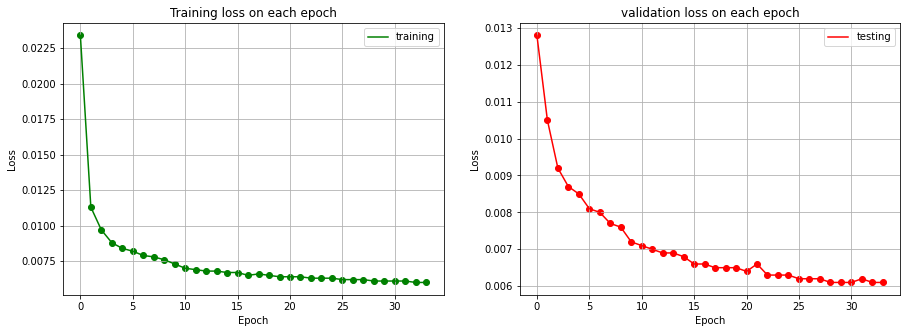

In [ ]:
#model.history.history
plt.figure(figsize=(15,5))
epochs = [i for i in range(34)]
plot_(epochs,loss,'',1,2,1,'Training loss on each epoch','Epoch','Loss','training',False,'g')
plot_(epochs,val_loss,'',1,2,2,'validation loss on each epoch','Epoch','Loss','testing',False,'r')

*    Their is a strict decrement in the loss for both training and validation.
*    After 30 epochs achieved 0.0061 loss

**Loading the trained model:**

In [ ]:
model = load_model("/content/drive/My Drive/encoder_model.h5")
model.compile(optimizer=optimizer, loss='mse') 

**Model Testing:**

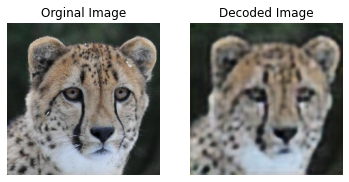

In [ ]:
sample_image = train_data[7]
sample_image = np.expand_dims(sample_image,axis=0)
image = model.predict(sample_image)
plot_(sample_image[0,:,:,:],'','',1,2,1,"Orginal Image","","","",True)
plot_(image[0,:,:],'','',1,2,2,"Decoded Image","","","",True)
plt.show()

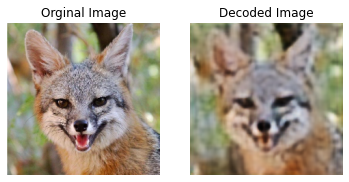

In [ ]:
sample_image = train_data[2396]
sample_image = np.expand_dims(sample_image,axis=0)
image = model.predict(sample_image)
plot_(sample_image[0,:,:,:],'','',1,2,1,"Orginal Image","","","",True)
plot_(image[0,:,:],'','',1,2,2,"Decoded Image","","","",True)
plt.show()

**Restoring the Best Model using Model Checkpoint:**

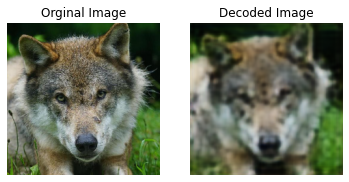

In [ ]:
model = load_model('/content/drive/My Drive/encoder_model.h5')
sample_image = train_data[15]
sample_image = np.expand_dims(sample_image,axis=0)
image = model.predict(sample_image)
plot_(train_data[15],'','',1,2,1,"Orginal Image","","","",True)
plot_(image[0,:,:],'','',1,2,2,"Decoded Image","","","",True)
plt.show()

*    Restorations seems really satisfactory. Images on the left side are original images whereas images on the right side are restored from compressed representation.
*    Decoded image is much flexible and efficient to work rather than working with original image since the compressed representation takes 8 times less space to original image.


# **Feature Extraction:**

In [ ]:
from keras import backend as K
def feature_extraction(model, data, layer = 4):

    """
    Creating a function to run the initial layers of the encoder model. (to get feature extraction from any layer of the model)
    Arguments:
    model - (Auto encoder model) - Trained model
    data - (np.ndarray) - list of images to get feature extraction from trained model
    layer - (int) - from which layer to take the features(by default = 4)
    Returns:
    pooled_array - (np.ndarray) - array of extracted features of given images
    """

    encoded = K.function([model.layers[0].input],[model.layers[layer].output])
    encoded_array = encoded([data])[0]
    pooled_array = encoded_array.max(axis=-1)
    return encoded_array
encoded = feature_extraction(model,train_data[:10],12)

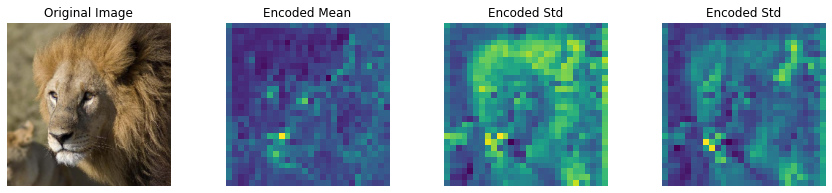

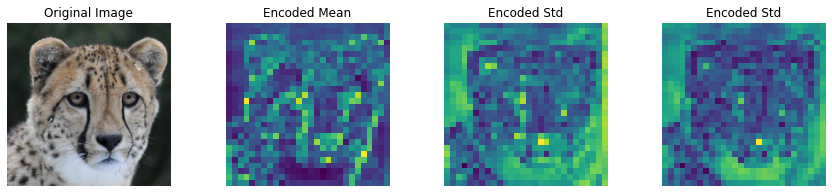

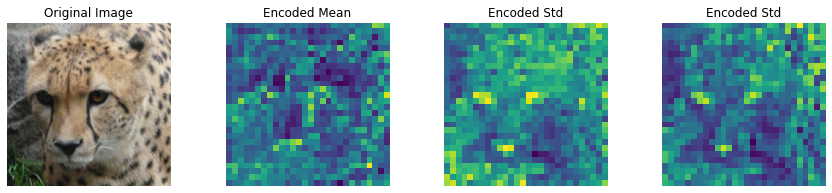

In [ ]:
for index in [2,7,9]:   # 3 random images
    plt.figure(figsize=(15,3))
    plot_(train_data[index],'','',1,4,1,"Original Image","","",'',True)
    plot_(encoded[index].mean(axis=-1),'','',1,4,2,"Encoded Mean","","",'',True)
    plot_(encoded[index].max(axis=-1),'','',1,4,3,"Encoded Std","","",'',True)
    plot_(encoded[index].std(axis=-1),'','',1,4,4,"Encoded Std","","",'',True)
    plt.show()

*    Extracting features from the 12th layer.
*    Dark pixels(yellow) indicates the high activation which helps in differentiating with other images.


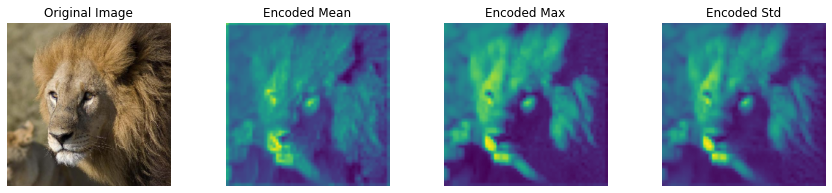

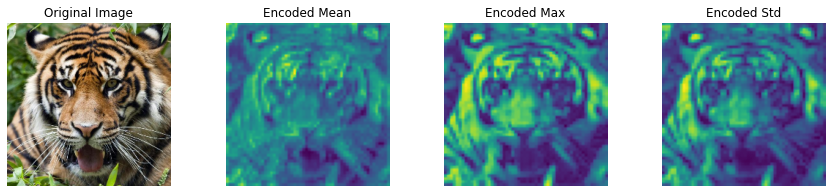

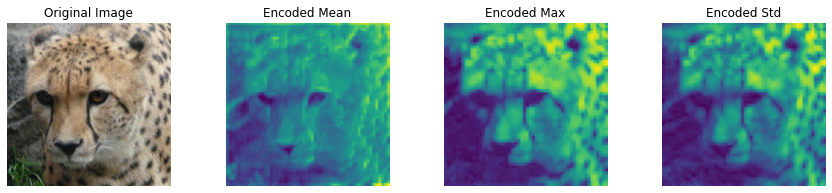

In [ ]:
encoded = feature_extraction(model,train_data[:10],9)
for index in [2,6,9]:   # 3 random images
    plt.figure(figsize=(15,3))
    plot_(train_data[index],'','',1,4,1,"Original Image","","",'',True)
    plot_(encoded[index].mean(axis=-1),'','',1,4,2,"Encoded Mean","","",'',True)
    plot_(encoded[index].max(axis=-1),'','',1,4,3,"Encoded Max","","",'',True)
    plot_(encoded[index].std(axis=-1),'','',1,4,4,"Encoded Std","","",'',True)
    plt.show()

Extracting features from the 9th layer.
Dark pixels(yellow) indicates the high activation which helps in differentiating with other images.
1. High activation on mane of lion.
2. Nose and lines on tigers.
3. Dots and lines on the nose for cheetah.
4. Nose on foxes.
These activation helps in label classification.

In [ ]:
def get_batches(data, batch_size=1000):

    """
    Taking batch of images for extraction of images.
    Arguments:
    data - (np.ndarray or list) - list of image array to get extracted features.
    batch_size - (int) - Number of images per each batch
    Returns:
    list - extracted features of each images
    """

    if len(data) < batch_size:
        return [data]
    n_batches = len(data) // batch_size
    
    # If batches fit exactly into the size of df.
    if len(data) % batch_size == 0:
        return [data[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]   

    # If there is a remainder.
    else:
        return [data[i*batch_size:min((i+1)*batch_size, len(data))] for i in range(n_batches+1)]

In [ ]:
d = np.concatenate([train_data,test_data],axis=0)
d.shape

(4738, 224, 224, 3)

In [ ]:
X_encoded = []
i=0
# Iterate through the full training set.
for batch in get_batches(d, batch_size=300):
    i+=1
    # This line runs our pooling function on the model for each batch.
    X_encoded.append(feature_extraction(model, batch),12)
    
X_encoded = np.concatenate(X_encoded)

In [ ]:
X_encoded.shape 

(4738, 7, 7, 512)

In [ ]:
X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1]*X_encoded.shape[2]*X_encoded.shape[3])
print('Encoded shape:', X_encoded_reshape.shape)
np.save('/content/drive/My Drive/X_encoded_compressed.npy',X_encoded_reshape)

Encoded shape: (4738, 25088)


In [ ]:
X_encoded = np.load('/content/drive/My Drive/X_encoded_compressed.npy')
X_encoded.shape

(4738, 25088)

In [ ]:
lisp=train_files
lisp.extend(test_files)
print(len(lisp))

4738


**Dimensionality Reduction through T-SNE:**

In [ ]:
transform = TSNE 
trans = transform(n_components=2) 
values = trans.fit_transform(X_encoded_reshape) 

In [ ]:
def plot_(x,y1,y2,row,col,ind,title,xlabel,ylabel,label,isimage=False,color='b'):

    """
    This function is used for plotting images and graphs (Visualization of end results of model training)
    Arguments:
    x - (np.ndarray or list) - an image array
    y1 - (list) - for plotting graph on left side.
    y2 - (list) - for plotting graph on right side.
    row - (int) - row number of subplot 
    col - (int) - column number of subplot
    ind - (int) - index number of subplot
    title - (string) - title of the plot 
    xlabel - (list) - labels of x axis
    ylabel - (list) - labels of y axis
    label - (string) - for adding legend in the plot
    isimage - (boolean) - True in case of image else False
    color - (char) - color of the plot (prefered green for training and red for testing).
    """
    
    plt.subplot(row,col,ind)
    if isimage:
        plt.imshow(x)
        plt.title(title)
        plt.axis('off')
    else:
        plt.plot(y1,label=label,color='g'); plt.scatter(x,y1,color='g')
        if y2!='': plt.plot(y2,color=color,label='validation'); plt.scatter(x,y2,color=color)
        plt.grid()
        plt.legend()
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

In [ ]:
lisp=train_files
lisp.extend(test_files)
print(len(lisp))

4738


# **Clustering Image Data:(K-Means)**

**Plotting few images of each cluster:**

In [ ]:
K = [4,5,6,7]
for k in K:
    print("if Number of clusters: "+str(k))
    kmeans = KMeans(n_clusters = k, random_state=0).fit(X_encoded_reshape)
    labels=kmeans.labels_
    centroids = kmeans.cluster_centers_
    plt.figure(figsize=(10,5)) 
    plt.subplot(1,1,1)
    plt.scatter(values[:,0], values[:,1], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c=None, s=50)
    plt.show()
    for row in range(k): 
        iter=0
        plt.figure(figsize=(13,3))
        for i,iterator in enumerate(labels):
            if iterator == row:
                img = cv2.imread("/content/dataset/"+lisp[i])
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                plot_(img,"","",1,6,iter+1,"cluster="+str(row),"","","",True)
                iter+=1
            if iter>=5: break
        plt.show()
    print() 

Output hidden; open in https://colab.research.google.com to view.

with cluster = 4
1. lions into first cluster.
2. cheetahs into second cluster.
3. foxes into third cluster.
4. Tigers into fourth cluster.

with cluster = 5
1. foxes into first cluster.
2. cheetahs into second cluster.
3. lions into third cluster.
4. Tigers into fourth cluster.
5. Tiger images with different lighthing conditions and white tigers into fifth cluster.

with cluster = 6
1. cheetahs into first cluster.
2. lions into second cluster.
3. snow dogs into third, tigers into fourth cluster.
4. leopards into fifth cluster.
5. foxes into sixth cluster. (**optimal parameter**)

with cluster = 7
1. Taking white tigers,cheetahs into separate cluster.

In [ ]:
#Training the model with optimial K value (6 in our case)
kmeans = KMeans(n_clusters = 6, random_state=0).fit(X_encoded_reshape)
labels=kmeans.labels_
centroids = kmeans.cluster_centers_

**Storing the model for future reference:**

In [ ]:
kmeans_file = '/content/drive/My Drive/kmeans_model.pkl'
joblib.dump(kmeans,kmeans_file)

In [ ]:
clusters_features = []
cluster_files=[]
for i in [0,1,2,3,4,5]:
    i_cluster = []
    i_labels=[]
    for iter,j in enumerate(kmeans.labels_):
        if j==i:
            i_cluster.append(X_encoded_reshape[iter])
            i_labels.append(lisp[iter])
    i_cluster = np.array(i_cluster)
    clusters_features.append(i_cluster)
    cluster_files.append(i_labels)

In [ ]:
labels=[]
data=[]
files=[]
for iter,i in enumerate(clusters_features):
    data.extend(i)
    labels.extend([iter for i in range(i.shape[0])])
    files.extend(cluster_files[iter])
print(np.array(labels).shape)
print(np.array(data).shape)
print(np.array(files).shape)

(4738,)
(4738, 25088)
(4738,)


# **Finding Nearest Neighbors(K-NN):**

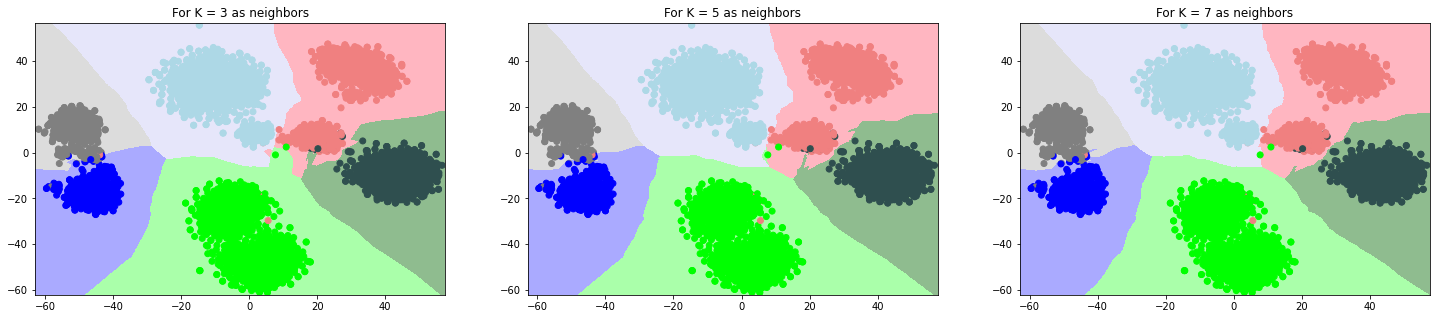

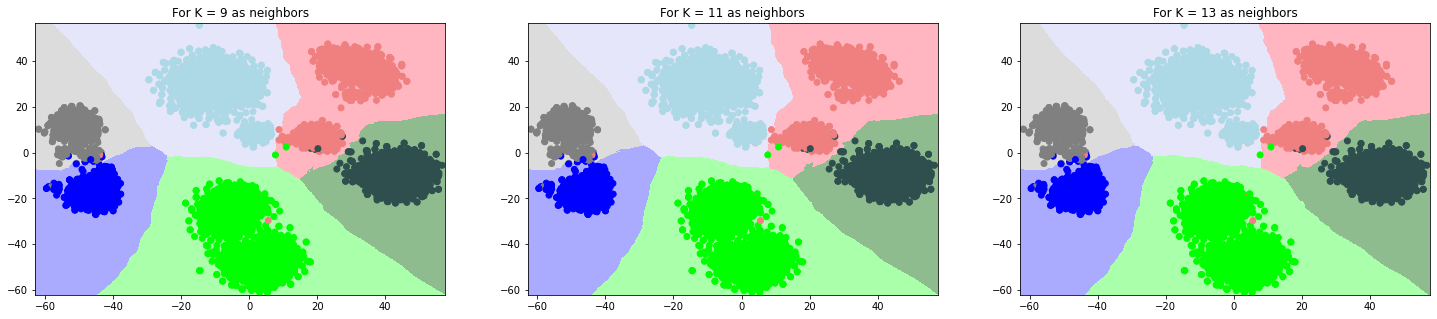

In [ ]:
for i in [[3,5,7],[9,11,13]]:
    plt.figure(figsize=(25,5))
    for iter,j in enumerate(i):
        n_neighbors = j
        X = values  
        y = labels
        h = .09  # step size in the mesh
        cmap_light = ListedColormap(['#FFB6C1', '#AAFFAA', '#AAAAFF','#E6E6FA','#8FBC8F','#DCDCDC'])
        cmap_bold = ListedColormap(['#F08080', '#00FF00', '#0000FF','#ADD8E6','#2F4F4F','#808080'])
        clf = KNeighborsClassifier(n_neighbors)
        clf.fit(X, y)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        plt.subplot(1,3,iter+1)
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points 
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("For K = {} as neighbors".format(j))
    plt.show()    

**Training the model with optimal hyperparameter:**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9,algorithm='ball_tree',n_jobs=-1)
knn.fit(np.array(data),np.array(labels))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='uniform')

**Storing the model for future reference:**

In [ ]:
knn_file = '/content/drive/My Drive/knn_model.pkl'
joblib.dump(knn,knn_file)

In [ ]:
def results_(query,result):
    
    """
    Plotting the N similar images from the dataset with query image.
    Arguments:
    query - (string) - filename of the query image
    result - (list) - filenames of similar images
    """

    def read(img):
        image = cv2.imread('/content/dataset/'+img)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        return image
    plt.figure(figsize=(10,5))
    if type(query)!=type(30):
        plot_(query,"","",1,1,1,"Query Image","","","",True)
    else:
        plot_(read(files[query]),"","",1,1,1,"Query Image "+files[query],"","","",True)
    plt.show()
    plt.figure(figsize=(20,5))
    for iter,i in enumerate(result):
        plot_(read(files[i]),"","",1,len(result),iter+1,files[i],"","","",True)
    plt.show()

# **Image Similarity Model**

**Making predictions:**

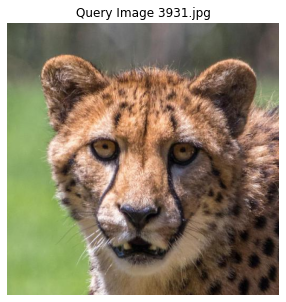

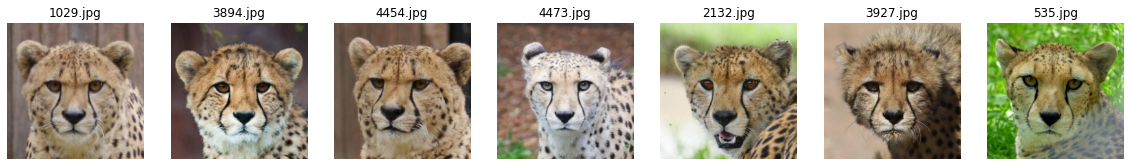

In [ ]:
num = 10 #datapoint
res = knn.kneighbors(data[num].reshape(1,-1),return_distance=True,n_neighbors=8)
results_(num,list(res[1][0])[1:])

In [ ]:
def predictions(label,N=8,isurl=False):

    """
    Making predictions for the query images and returns N similar images from the dataset.
    We can either pass filename or the url for the image.
    Arguments:
    label - (string) - file name of the query image.
    N - (int) - Number of images to be returned
    isurl - (string) - if query image is from google is set to True else False(By default = False)
    """

    if isurl:
        img = io.imread(label)
        img = cv2.resize(img,(224,224))
    else:
        img_path = '/content/dataset/'+label
        img = image.load_img(img_path, target_size=(224,224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data,axis=0)
    img_data = preprocess_input(img_data)
    feature = K.function([model.layers[0].input],[model.layers[12].output])
    feature = np.array(feature).flatten().reshape(1,-1)
    res = knn.kneighbors(feature.reshape(1,-1),return_distance=True,n_neighbors=N)
    results_(img,list(res[1][0])[1:])

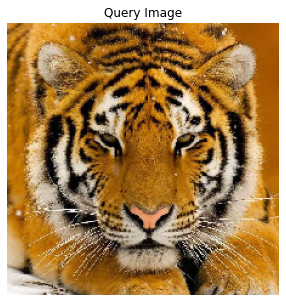

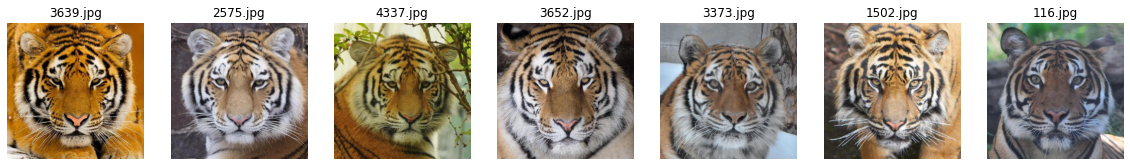

In [ ]:
query_path = '2427.jpg'
predictions(query_path)

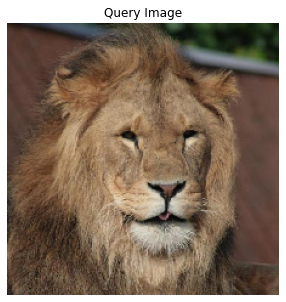

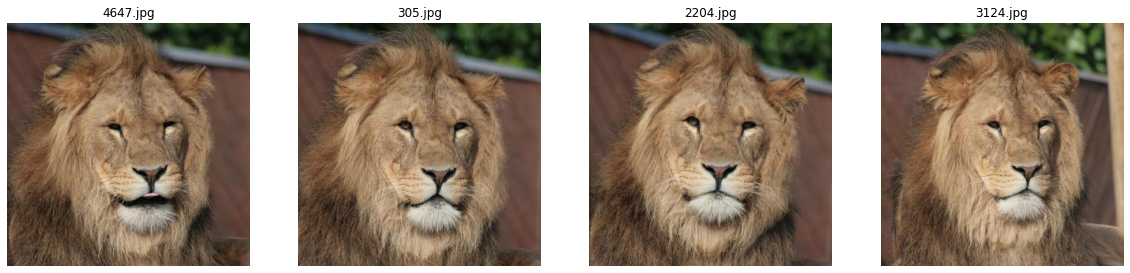

In [ ]:
query_path = '4160.jpg'
predictions(query_path,5)

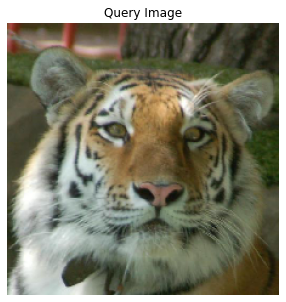

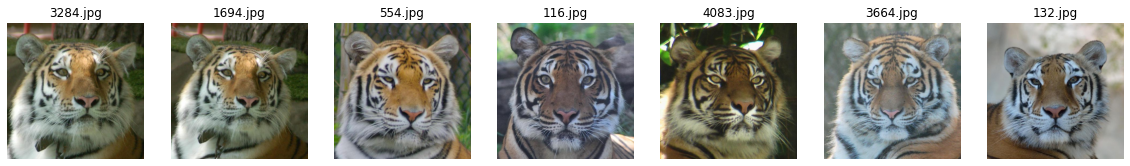

In [ ]:
query_path = '1127.jpg'
predictions(query_path)

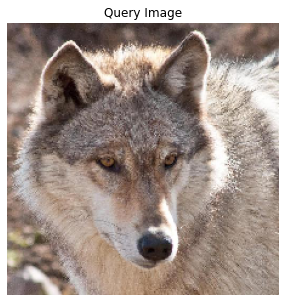

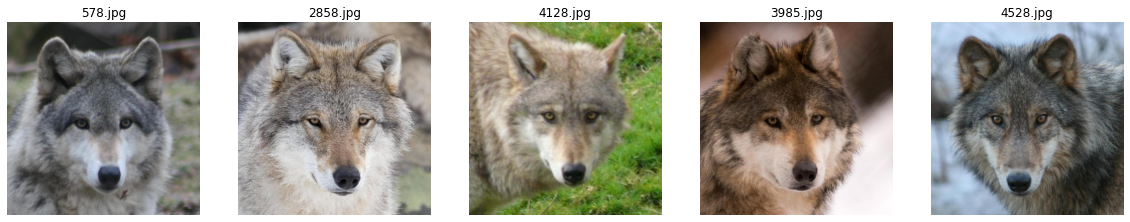

In [ ]:
query_path = '1379.jpg'
predictions(query_path,6)

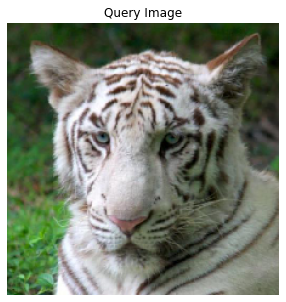

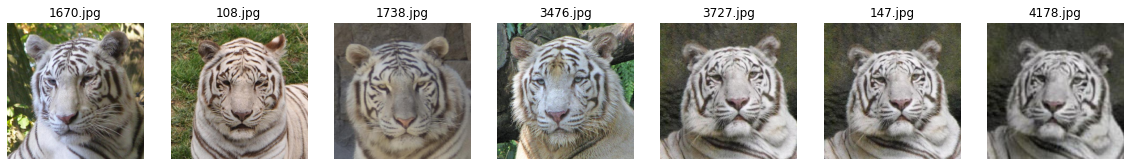

In [ ]:
query_path = '608.jpg'
predictions(query_path)

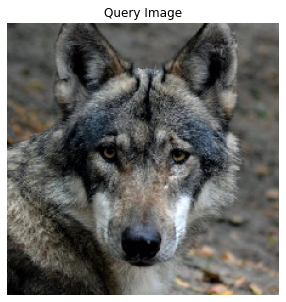

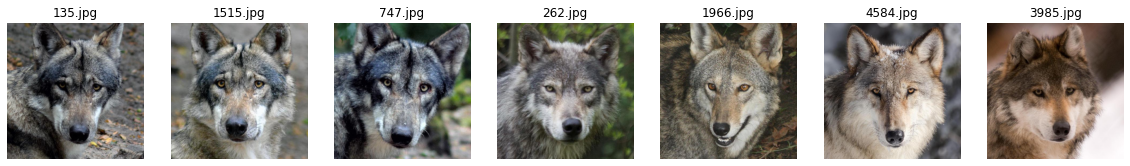

In [ ]:
query_path = '2550.jpg'
predictions(query_path)

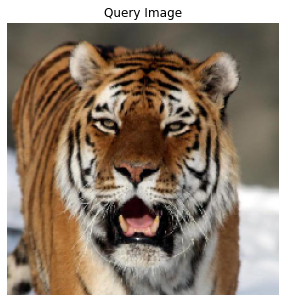

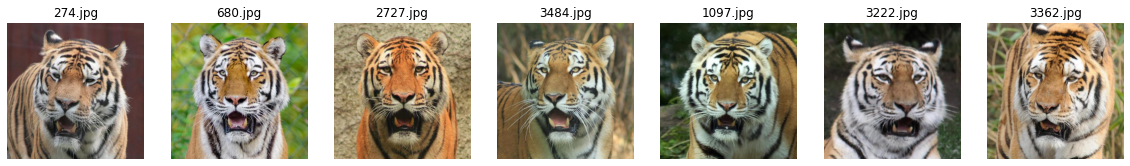

In [ ]:
query_path = '167.jpg'
predictions(query_path)

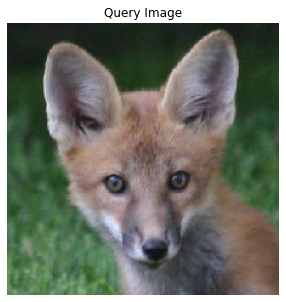

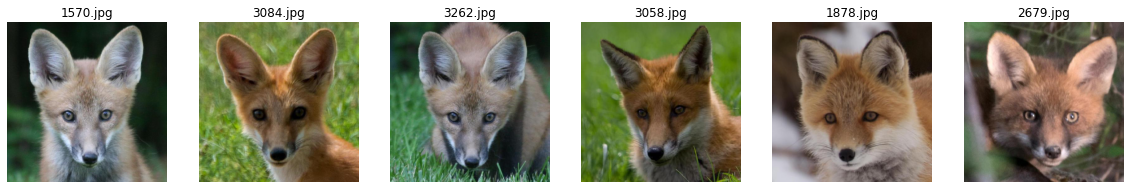

In [ ]:
query_path = '543.jpg'
predictions(query_path,7)

**Testing with google images:**

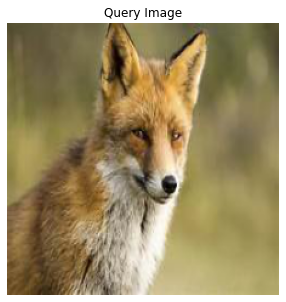

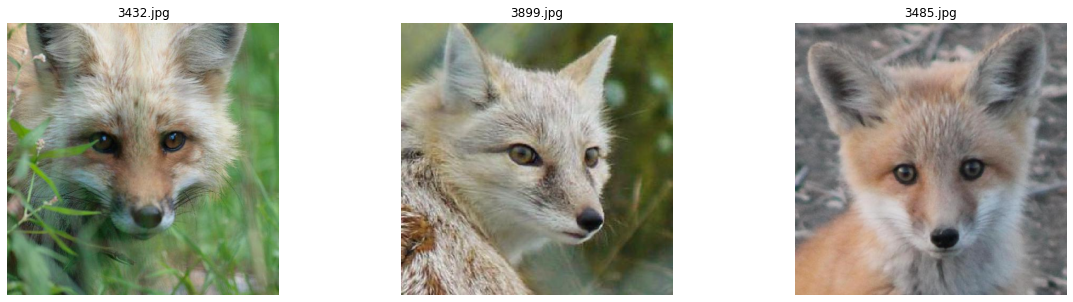

In [ ]:
import imageio as io
query_path = 'https://tse4.mm.bing.net/th?id=OIP.NIMP0bTfhF3898t_ZYLB8QHaE8&pid=Api&P=0&w=248&h=166'
predictions(query_path,4,isurl=True)

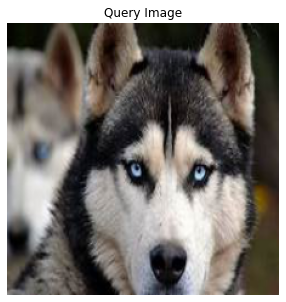

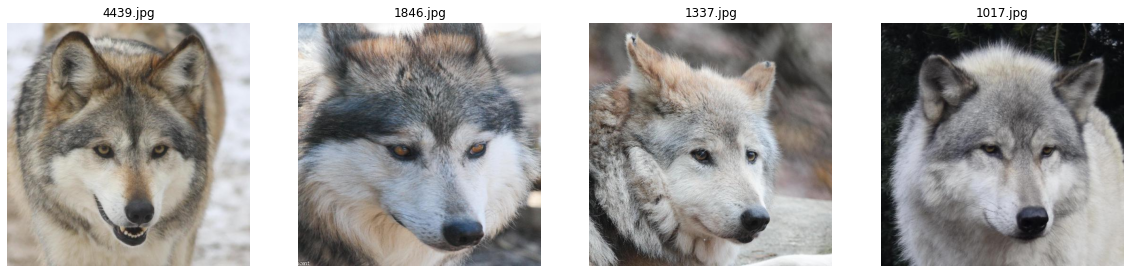

In [ ]:
query_path = 'https://tse4.mm.bing.net/th?id=OIP.dr7YkzR28BFJerLKJc4cLgHaE7&pid=Api&P=0&w=242&h=162'
predictions(query_path,5,isurl=True)

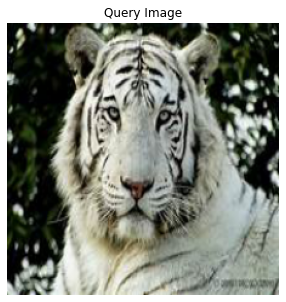

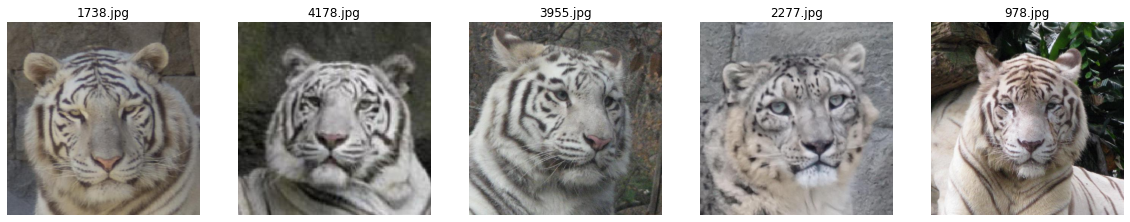

In [ ]:
query_path = 'https://tse2.mm.bing.net/th?id=OIP.EkSb6SADo3WRj2WFQWTBvgHaFj&pid=Api&P=0&w=216&h=163'
predictions(query_path,6,isurl=True)